In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import time
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Load the dataset
bike_data = pd.read_csv('SeoulBikeData.csv', sep=",",encoding = "ISO-8859-1")
# Check the structure of the data
print(bike_data.head())
bike_data.replace("?", np.NaN, inplace = True) # replace "?" with np.Nan
null_values = bike_data.isnull().sum() 
print(null_values)
print ()
print("-"*50)
df = bike_data.copy()
def f(x):
    if (x > 5) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Afternoon'
    elif (x > 16) and (x <= 20) :
        return 'Evening'
    elif (x > 20) and (x <= 5):
        return'Night'    
b = [0,5,8,12,16,20]
l = ['Early Morning','Morning','Afternoon','Evening','Night']
df["hourOfDay"] = pd.cut(df['Hour'], bins=b, labels=l, include_lowest=True)
df.drop("Hour",axis=1, inplace=True)
df.drop("Date", axis = 1, inplace = True) # Date column is useless in prediction
print()
print("-"*50)
#Converting string to numerical data
label_encoder = LabelEncoder()
df["Seasons"]=label_encoder.fit_transform(pd.Categorical(df["Seasons"],categories=['Winter','Spring','Summer','Autumn'],ordered=True))
df["Holiday"]=label_encoder.fit_transform(pd.Categorical(df["Holiday"],categories=['No Holiday','Holiday']))
df["Functioning Day"]=label_encoder.fit_transform(pd.Categorical(df["Functioning Day"],categories=['No', 'Yes']))
df["hourOfDay"]=label_encoder.fit_transform(df["hourOfDay"])
#df["Seasons"] = pd.Categorical(df["Seasons"],categories=['Winter','Spring','Summer','Autumn'],ordered=True)
#df["Holiday"] = pd.Categorical(df["Holiday"],categories=['No Holiday','Holiday']
#df["Functioning Day"] = pd.Categorical(df["Functioning Day"],categories=['No', 'Yes'])
#df['Functioning Day'] = df['Functioning Day'].cat.codes
#df['Holiday'] = df['Holiday'].cat.codes
#df['Seasons'] = df['Seasons'].cat.codes
#df['hourOfDay'] = df['hourOfDay'].cat.codes
print(df.dtypes)
print("-"*50)
#To find the outliers by using Z score
def find_outliers_z_score(df : pd.DataFrame) -> []:
    outliers_index =[]
    for column in ["Temperature(°C)","Humidity(%)","Wind speed (m/s)","Visibility (10m)",
                   "Solar Radiation (MJ/m2)","Snowfall (cm)","Rainfall(mm)"]:
        mean = df[column].mean()
        std_deviation = df[column].std()
        z_scores = (df[column] - mean) / std_deviation
        outliers = df[np.abs(z_scores) > 3]
        outliers_index.extend(df.index[np.abs(z_scores) > 3])
        print("Outliers for Column: ",column)
        if len(outliers) > 0:
            print(outliers)
        else:
            print("No outliers")
    return outliers_index
#To remove Outliers using z score
def remove_outliers(df: pd.DataFrame, lst: []) ->pd.DataFrame:
    lst=sorted(set(lst))
    df=df.drop(lst)
    return df
print("-"*50)
print("Outliers according to Z score") # outliers are points with a z score greater than 3
outliers_index=find_outliers_z_score(bike_data)
#bike_data=remove_outliers(bike_data,outliers_index)
print("Count ",len(outliers_index))
print()
print("-"*50)
df.to_csv("Bike Data.csv")
print(df.describe())
df.head(200)
# Split features and target
X = pd.DataFrame(df.drop(["Rented Bike Count","Dew point temperature(°C)"], axis=1))
y = pd.DataFrame(df[["Rented Bike Count"]])
print(X.isna().sum())
# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# print(X_train.isna().sum(), 'hi*'*10)
# print(y_train.isna().sum())
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

Using device: cpu
         Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0  01/12/2017                254     0             -5.2           37   
1  01/12/2017                204     1             -5.5           38   
2  01/12/2017                173     2             -6.0           39   
3  01/12/2017                107     3             -6.2           40   
4  01/12/2017                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Wint

In [2]:
# 2-Layer Neural Network
class NeuralNet2L(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation_fn):
        super(NeuralNet2L, self).__init__()
        print(input_size, hidden_size, output_size)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = activation_fn
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.activation(out)
        out = self.fc2(out)
        return out
# 3-Layer Neural Network
class NeuralNet3L(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation_fn):
        super(NeuralNet3L, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = activation_fn
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.activation(out)
        out = self.fc2(out)
        out = self.activation(out)
        out = self.fc3(out)
        return out
# XL Neural Network
class NeuralNetXL(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation_fn):
        super(NeuralNetXL, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation = activation_fn
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.activation(out)
        out = self.fc2(out)
        out = self.activation(out)
        out = self.fc3(out)
        out = self.activation(out)
        out = self.fc4(out)
        return out


In [3]:
# Define activation functions
activation_functions = {
    'ReLU': nn.ReLU(),
    'Tanh': nn.Tanh(),
    'Sigmoid': nn.Sigmoid(),
    'LeakyReLU': nn.LeakyReLU(),
    'ELU': nn.ELU(),
    'SELU': nn.SELU(),
    'GELU': nn.GELU(),
    'Softplus': nn.Softplus(),
    'Softsign': nn.Softsign()
}
# Define optimizers
optimizer_list = ['SGD', 'Adam', 'RMSprop', 'NAdam']
default_learning_rates = {
   'SGD': 1e-5,
    'Adam': 1e-5,
    'RMSprop': 1e-5,
    'NAdam': 1e-5
}


In [4]:
def get_optimizer_and_scheduler(optimizer_name, model_parameters):
    lr = default_learning_rates[optimizer_name]
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model_parameters, lr=lr, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model_parameters, lr=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model_parameters, lr=lr)
    elif optimizer_name == 'NAdam':
        optimizer = optim.NAdam(model_parameters, lr=lr)
    else:
        raise ValueError(f"Optimizer {optimizer_name} not recognized.")
    # Define a scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
    return optimizer, scheduler


In [5]:
from sklearn.metrics import mean_squared_error, r2_score
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True)
# Define the loss function
criterion = nn.MSELoss()
def check_for_nans(tensor, tensor_name):
    has_nan = torch.isnan(tensor).any()
    has_inf = torch.isinf(tensor).any()
    print(f"{tensor_name} contains NaN: {has_nan}, contains Inf: {has_inf}")
check_for_nans(X_train, "X_train")
check_for_nans(y_train, "y_train")
check_for_nans(X_test, "X_test")
check_for_nans(y_test, "y_test")


X_train contains NaN: False, contains Inf: False
y_train contains NaN: False, contains Inf: False
X_test contains NaN: False, contains Inf: False
y_test contains NaN: False, contains Inf: False


In [6]:

def train_model(model, criterion, optimizer, scheduler, train_loader, num_epochs=100):
            model.train()
            for epoch in range(num_epochs):
                epoch_loss = 0.0
                for inputs, targets in train_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    if torch.isnan(loss):
                        print(f"NaN loss encountered at epoch {epoch+1}")
                        return model

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    epoch_loss += loss.item()

                scheduler.step()
                avg_loss = epoch_loss / len(train_loader)
                if (epoch+1)==100:
                    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")
            return model


In [7]:
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        # Convert tensors to numpy arrays
        y_pred = predictions.cpu().numpy()
        y_true = y_test.cpu().numpy() 
        # Check for NaNs in predictions and true labels
        if np.isnan(y_pred).any():
            print("NaNs detected in model predictions.")
            return np.nan, np.nan, np.nan, np.nan, None, None
        if np.isnan(y_true).any():
            print("NaNs detected in true labels.")
            return np.nan, np.nan, np.nan, np.nan, None, None
        # Calculate metrics
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        sse = np.sum((y_true - y_pred) ** 2)
    return mse, rmse, r2, sse, y_true, y_pred  # Return y_true and y_pred for plotting


In [8]:
from sklearn.model_selection import KFold
# Define 5-fold cross-validation with shuffling and a fixed random state for reproducibility
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Helper function to evaluate the model with 5-fold cross-validation
def cross_val_evaluate(model, X, y, criterion, optimizer_name, activation_name):
    mse_scores = []   # To store MSE for each fold
    rmse_scores = []  # To store RMSE for each fold
    r2_scores = []    # To store R² for each fold
    y_true_all = []   # To store true values across folds for plotting
    y_pred_all = []   # To store predicted values across folds for plotting
    print("5-fold cross-validation evaluation")
    # Loop through each folda
    for train_index, val_index in kf.split(X):
        # Split the data into training and validation sets for the current fold
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]   
        # Initialize model, optimizer, and scheduler for the fold
        model_fold = model  # Re-initialize model for each fold
        optimizer, scheduler = get_optimizer_and_scheduler(optimizer_name, model_fold.parameters())
        # Train the model on the current fold
        model_fold = train_model(model_fold, criterion, optimizer, scheduler, train_loader, num_epochs=100)
        # Evaluate the model on the validation fold
        mse, rmse, r2, _, y_true_fold, y_pred_fold = evaluate_model(model_fold, X_val_fold, y_val_fold)
        mse_scores.append(mse)  # Save MSE for this fold
        rmse_scores.append(rmse)  # Save RMSE for this fold
        r2_scores.append(r2)  # Save R² for this fold
        # Append true and predicted values for each fold for plotting
        y_true_all.extend(y_true_fold)
        y_pred_all.extend(y_pred_fold)
    # Calculate average metrics across all folds
    avg_mse = np.mean(mse_scores)
    avg_rmse = np.mean(rmse_scores)
    avg_r2 = np.mean(r2_scores)
    return avg_mse, avg_rmse, avg_r2, np.array(y_true_all), np.array(y_pred_all)  # Return average metrics and all true/predicted values


In [9]:
num_epochs = 100  
model_metrics = {}
for activation_name, activation_fn in activation_functions.items():
    for optimizer_name in optimizer_list:
        print(f"Testing Activation: {activation_name}, Optimizer: {optimizer_name}")
        input_size_2L = 11     # Based on 11 features
        hidden_size_2L = 512    # Smaller hidden layer
        output_size_2L = 1     # Predicting a single value (mpg)
        # 3-Layer Neural Network (moderate complexity)a
        input_size_3L = 11   # Same input size
        hidden_size_3L = 512  # Larger hidden layer
        output_size_3L = 1     # Predicting a single value (mpg)
        # XL Model (complex model with more layers or larger hidden size)
        input_size_XL = 11      # Same input size
        hidden_size_XL = 512   # Even larger hidden layer
        output_size_XL = 1     # Predicting a single value (mpg)
        # Define model configurations
        model_2L = NeuralNet2L(input_size_2L, hidden_size_2L, output_size_2L, activation_fn).to(device)
        model_3L = NeuralNet3L(input_size_3L, hidden_size_3L, output_size_3L, activation_fn).to(device)
        model_XL = NeuralNetXL(input_size_XL, hidden_size_XL, output_size_XL, activation_fn).to(device)
        # Get optimizer and scheduler for each model
        optimizer_2L, scheduler_2L = get_optimizer_and_scheduler(optimizer_name, model_2L.parameters())
        optimizer_3L, scheduler_3L = get_optimizer_and_scheduler(optimizer_name, model_3L.parameters())
        optimizer_XL, scheduler_XL = get_optimizer_and_scheduler(optimizer_name, model_XL.parameters())
        # Train models
        print("training 2L net")
        model_2L = train_model(model_2L, criterion, optimizer_2L, scheduler_2L, train_loader)
        print("training 3l net")
        model_3L = train_model(model_3L, criterion, optimizer_3L, scheduler_3L, train_loader)
        print("training Xl net")
        model_XL = train_model(model_XL, criterion, optimizer_XL, scheduler_XL, train_loader)
        # Evaluate models
        print("starting evaluation")
        train_mse_2L, train_rmse_2L, train_r2_2L, train_sse_2L, y_true_train_2L, y_pred_train_2L = evaluate_model(model_2L, X_train, y_train)
        test_mse_2L, test_rmse_2L, test_r2_2L, test_sse_2L, y_true_test_2L, y_pred_test_2L = evaluate_model(model_2L, X_test, y_test)
        
        train_mse_3L, train_rmse_3L, train_r2_3L, train_sse_3L, y_true_train_3L, y_pred_train_3L = evaluate_model(model_3L, X_train, y_train)
        test_mse_3L, test_rmse_3L, test_r2_3L, test_sse_3L, y_true_test_3L, y_pred_test_3L = evaluate_model(model_3L, X_test, y_test)
        
        train_mse_XL, train_rmse_XL, train_r2_XL, train_sse_XL, y_true_train_XL, y_pred_train_XL = evaluate_model(model_XL, X_train, y_train)
        test_mse_XL, test_rmse_XL, test_r2_XL, test_sse_XL, y_true_test_XL, y_pred_test_XL = evaluate_model(model_XL, X_test, y_test)
        # Cross-validation results
        cv_mse_2L, cv_rmse_2L, cv_r2_2L,y_true_cv_2L,y_true_train_cv_2L = cross_val_evaluate(model_2L, X_train, y_train, criterion, optimizer_name, activation_name)
        cv_mse_3L, cv_rmse_3L, cv_r2_3L,y_true_cv_3L,y_true_train_cv_3L = cross_val_evaluate(model_3L, X_train, y_train, criterion, optimizer_name, activation_name)
        cv_mse_XL, cv_rmse_XL, cv_r2_XL,y_true_cv_XL,y_true_train_cv_XL = cross_val_evaluate(model_XL, X_train, y_train, criterion, optimizer_name, activation_name)
        # Store metrics and predictions in model_metrics
        key = f'Activation: {activation_name}, Optimizer: {optimizer_name}'
        model_metrics[key] = {
            '2-Layer Neural Network': {
                'In-Sample MSE': train_mse_2L, 'In-Sample RMSE': train_rmse_2L, 'In-Sample R²': train_r2_2L,
                'Validation MSE': test_mse_2L, 'Validation RMSE': test_rmse_2L, 'Validation R²': test_r2_2L,
                'Cross-Validation MSE': cv_mse_2L, 'Cross-Validation RMSE': cv_rmse_2L, 'Cross-Validation R²': cv_r2_2L,
                'y_true_train': y_true_train_2L, 'y_pred_train': y_pred_train_2L,
                'y_true_test': y_true_test_2L, 'y_pred_test': y_pred_test_2L
            },
            '3-Layer Neural Network': {
                'In-Sample MSE': train_mse_3L, 'In-Sample RMSE': train_rmse_3L, 'In-Sample R²': train_r2_3L,
                'Validation MSE': test_mse_3L, 'Validation RMSE': test_rmse_3L, 'Validation R²': test_r2_3L,
                'Cross-Validation MSE': cv_mse_3L, 'Cross-Validation RMSE': cv_rmse_3L, 'Cross-Validation R²': cv_r2_3L,
                'y_true_train': y_true_train_3L, 'y_pred_train': y_pred_train_3L,
                'y_true_test': y_true_test_3L, 'y_pred_test': y_pred_test_3L
            },
            'XL Neural Network': {
                'In-Sample MSE': train_mse_XL, 'In-Sample RMSE': train_rmse_XL, 'In-Sample R²': train_r2_XL,
                'Validation MSE': test_mse_XL, 'Validation RMSE': test_rmse_XL, 'Validation R²': test_r2_XL,
                'Cross-Validation MSE': cv_mse_XL, 'Cross-Validation RMSE': cv_rmse_XL, 'Cross-Validation R²': cv_r2_XL,
                'y_true_train': y_true_train_XL, 'y_pred_train': y_pred_train_XL,
                'y_true_test': y_true_test_XL, 'y_pred_test': y_pred_test_XL
            }
        }

Testing Activation: ReLU, Optimizer: SGD
11 512 1
training 2L net
Epoch [100/100], Loss: 151656.843750
training 3l net
Epoch [100/100], Loss: 109386.273438
training Xl net
Epoch [100/100], Loss: 893544.687500
starting evaluation
5-fold cross-validation evaluation
Epoch [100/100], Loss: 145072.476562
Epoch [100/100], Loss: 141301.726562
Epoch [100/100], Loss: 141973.593750
Epoch [100/100], Loss: 139124.375000
Epoch [100/100], Loss: 137281.640625
5-fold cross-validation evaluation
Epoch [100/100], Loss: 72947.910156
Epoch [100/100], Loss: 65347.671875
Epoch [100/100], Loss: 61678.671875
Epoch [100/100], Loss: 59671.933594
Epoch [100/100], Loss: 58625.492188
5-fold cross-validation evaluation
Epoch [100/100], Loss: 126593.761719
Epoch [100/100], Loss: 81941.535156
Epoch [100/100], Loss: 67459.714844
Epoch [100/100], Loss: 62496.414062
Epoch [100/100], Loss: 58378.474609
Testing Activation: ReLU, Optimizer: Adam
11 512 1
training 2L net
Epoch [100/100], Loss: 914240.312500
training 3l net


In [10]:
print("\nModel Performance Comparison:")
for model_name, metrics in model_metrics.items():
    print(f"\n{model_name}:")
    for metric_name, metric_value in metrics.items():
        # Skip printing y_pred and y_true arrays
        if metric_value in ['y_true_train', 'y_pred_train']:
            continue
        if isinstance(metric_value, float):
            print(f"  {metric_name}: {metric_value:.4f}")
        else:
            print(f"  {metric_name}: {metric_value}")



Model Performance Comparison:

Activation: ReLU, Optimizer: SGD:
  2-Layer Neural Network: {'In-Sample MSE': 151686.23, 'In-Sample RMSE': 389.46918, 'In-Sample R²': 0.6351996092078847, 'Validation MSE': 149774.14, 'Validation RMSE': 387.00665, 'Validation R²': 0.6405244057000494, 'Cross-Validation MSE': 141125.55, 'Cross-Validation RMSE': 375.61514, 'Cross-Validation R²': 0.6602152202785587, 'y_true_train': array([[ 995.],
       [1195.],
       [1448.],
       ...,
       [ 999.],
       [ 322.],
       [1501.]], dtype=float32), 'y_pred_train': array([[ 911.6751 ],
       [ 393.05557],
       [1233.5775 ],
       ...,
       [1161.738  ],
       [ 250.16228],
       [1651.5137 ]], dtype=float32), 'y_true_test': array([[1728.],
       [ 822.],
       [ 658.],
       ...,
       [ 179.],
       [ 294.],
       [ 673.]], dtype=float32), 'y_pred_test': array([[1152.7902  ],
       [1118.51    ],
       [1380.8085  ],
       ...,
       [ 857.1392  ],
       [  93.783134],
       [1463.16

In [11]:
best_performance = {
    '2-Layer Neural Network': {'R²': -float('inf'), 'Details': None},
    '3-Layer Neural Network': {'R²': -float('inf'), 'Details': None},
    'XL Neural Network': {'R²': -float('inf'), 'Details': None}
}
# Iterate through each configuration to find the best R² for each network type
for config, model_data in model_metrics.items():
    for model_name, metrics in model_data.items():
        validation_r2 = metrics['Validation R²']
        # Check if this is the best R² score for the current model type
        if validation_r2 > best_performance[model_name]['R²']:
            best_performance[model_name]['R²'] = validation_r2
            best_performance[model_name]['Details'] = {
                'Activation and Optimizer': config,
                'Metrics': metrics
            }
print("\nBest Performance for Each Neural Network:")
for model_name, performance in best_performance.items():
    print(f"\n{model_name}:")
    print(f"  Best R²: {performance['R²']:.4f}")
    print(f"  Activation and Optimizer: {performance['Details']['Activation and Optimizer']}")
    print("  Metrics:")
    for metric, value in performance['Details']['Metrics'].items():
        print(f"    {metric}: {value:.4f}" if isinstance(value, float) else f"    {metric}: {value}")



Best Performance for Each Neural Network:

2-Layer Neural Network:
  Best R²: 0.6405
  Activation and Optimizer: Activation: ReLU, Optimizer: SGD
  Metrics:
    In-Sample MSE: 151686.234375
    In-Sample RMSE: 389.46917724609375
    In-Sample R²: 0.6352
    Validation MSE: 149774.140625
    Validation RMSE: 387.00665283203125
    Validation R²: 0.6405
    Cross-Validation MSE: 141125.546875
    Cross-Validation RMSE: 375.6151428222656
    Cross-Validation R²: 0.6602
    y_true_train: [[ 995.]
 [1195.]
 [1448.]
 ...
 [ 999.]
 [ 322.]
 [1501.]]
    y_pred_train: [[ 911.6751 ]
 [ 393.05557]
 [1233.5775 ]
 ...
 [1161.738  ]
 [ 250.16228]
 [1651.5137 ]]
    y_true_test: [[1728.]
 [ 822.]
 [ 658.]
 ...
 [ 179.]
 [ 294.]
 [ 673.]]
    y_pred_test: [[1152.7902  ]
 [1118.51    ]
 [1380.8085  ]
 ...
 [ 857.1392  ]
 [  93.783134]
 [1463.1681  ]]

3-Layer Neural Network:
  Best R²: 0.7738
  Activation and Optimizer: Activation: SELU, Optimizer: SGD
  Metrics:
    In-Sample MSE: 90175.5234375
    

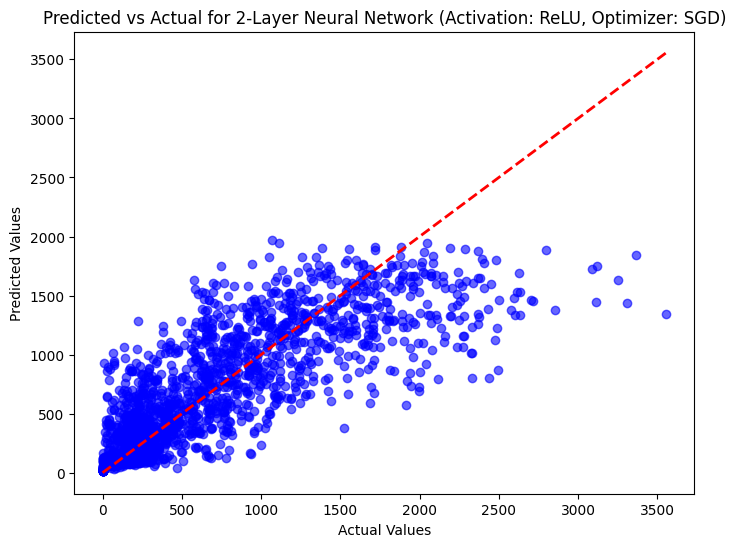

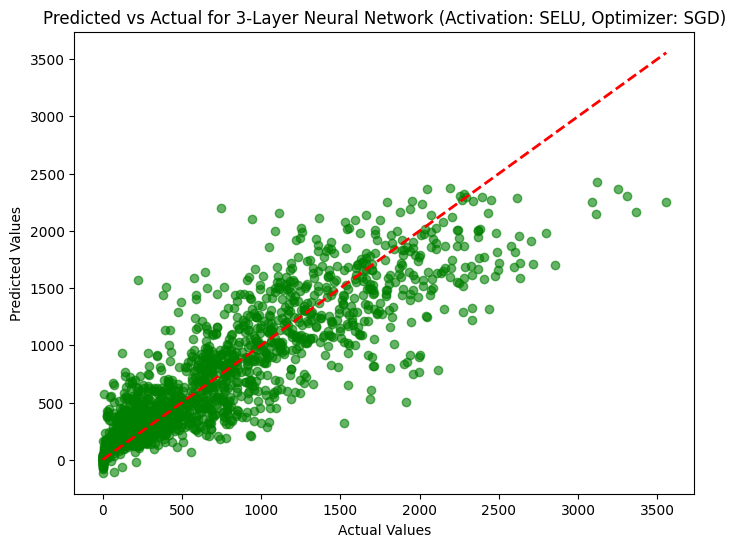

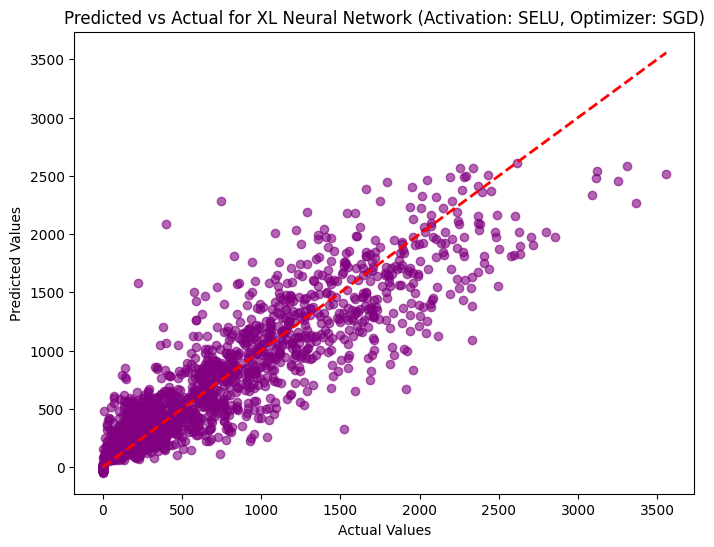

In [12]:
import matplotlib.pyplot as plt
# Function to plot predicted vs actual values with specified color
def plot_predicted_vs_actual(y_true, y_pred, title, color):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, color=color)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Predicted vs Actual for {title}")
    plt.show()
# Define colors for each model type
model_colors = {
    '2-Layer Neural Network': 'blue',
    '3-Layer Neural Network': 'green',
    'XL Neural Network': 'purple'
}
# Plot for each best-performing model configuration
for model_name, performance in best_performance.items():
    # Retrieve the best activation and optimizer configuration
    config = performance['Details']['Activation and Optimizer']
    # Retrieve y_true and y_pred from the best configuration
    y_true_test = performance['Details']['Metrics']['y_true_test']
    y_pred_test = performance['Details']['Metrics']['y_pred_test']
    # Plot predicted vs actual with specified color
    plot_predicted_vs_actual(y_true_test, y_pred_test, f"{model_name} ({config})", model_colors[model_name])


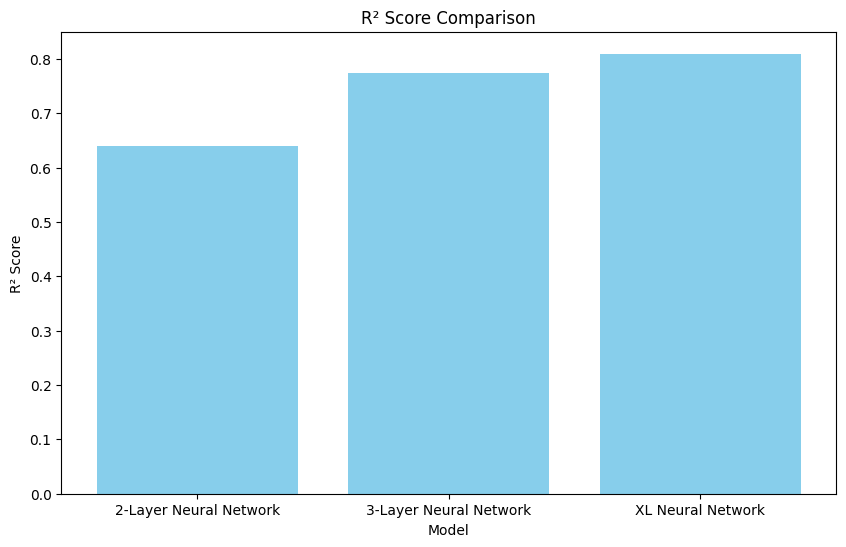

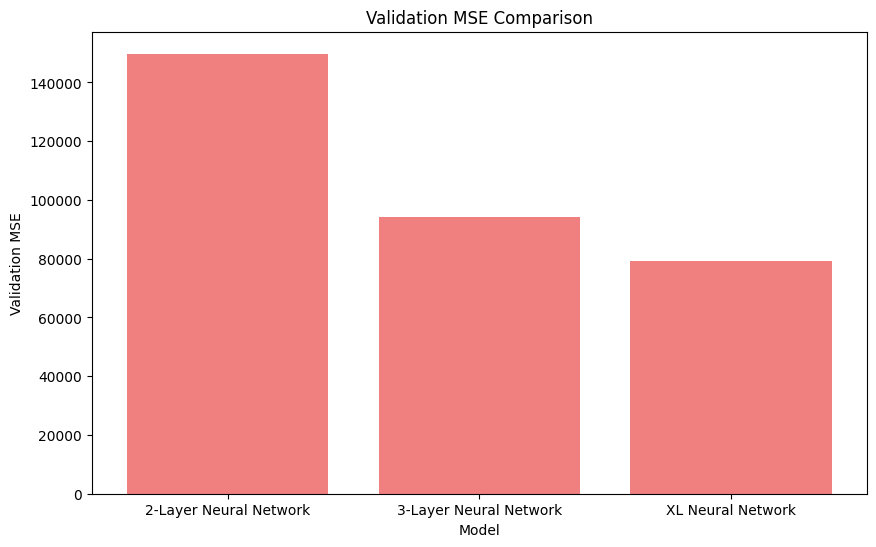

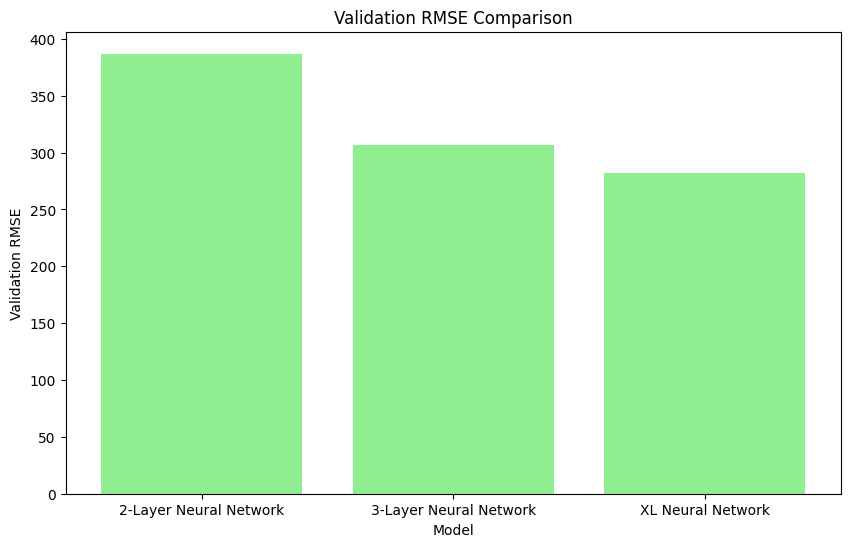

In [13]:
def plot_performance_metrics(best_performance):
    # Collect metrics for plotting
    models = list(best_performance.keys())
    r2_scores = [best_performance[model]['R²'] for model in models]
    mse_scores = [best_performance[model]['Details']['Metrics']['Validation MSE'] for model in models]
    rmse_scores = [best_performance[model]['Details']['Metrics']['Validation RMSE'] for model in models]
    # Plot R² Scores
    plt.figure(figsize=(10, 6))
    plt.bar(models, r2_scores, color='skyblue')
    plt.xlabel("Model")
    plt.ylabel("R² Score")
    plt.title("R² Score Comparison")
    plt.show()

    # Plot MSE Scores
    plt.figure(figsize=(10, 6))
    plt.bar(models, mse_scores, color='lightcoral')
    plt.xlabel("Model")
    plt.ylabel("Validation MSE")
    plt.title("Validation MSE Comparison")
    plt.show()

    # Plot RMSE Scores
    plt.figure(figsize=(10, 6))
    plt.bar(models, rmse_scores, color='lightgreen')
    plt.xlabel("Model")
    plt.ylabel("Validation RMSE")
    plt.title("Validation RMSE Comparison")
    plt.show()

# Call the function to display performance metrics
plot_performance_metrics(best_performance)


In [6]:
import torch
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train.cpu().numpy(), y_train.cpu().numpy().ravel())

# Make predictions on the test set
rf_predictions = rf_model.predict(X_test.cpu().numpy())

# Evaluate the model
rf_mse = mean_squared_error(y_test.cpu().numpy(), rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test.cpu().numpy(), rf_predictions)

# Display the evaluation metrics
print(f'Random Forest Test MSE : {rf_mse:.4f}')
print(f'Random Forest Test RMSE: {rf_rmse:.4f}')
print(f'Random Forest Test R²   : {rf_r2:.4f}')


Random Forest Test MSE : 76185.7484
Random Forest Test RMSE: 276.0177
Random Forest Test R²   : 0.8171


In [19]:
from sklearn.model_selection import GridSearchCV

# Example for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2
)

rf_grid.fit(X_train.cpu().numpy(), y_train.cpu().numpy().ravel())
print(f'Best Parameters: {rf_grid.best_params_}')
print(f'Best CV MSE: {rf_grid.best_score_:.4f}')

# Evaluate on Test Set
best_rf = rf_grid.best_estimator_
rf_test_predictions = best_rf.predict(X_test.cpu().numpy())
rf_test_mse = mean_squared_error(y_test.cpu().numpy(), rf_test_predictions)
rf_r2 = r2_score(y_test.cpu().numpy(), rf_test_predictions)
print(f'Best Random Forest Test MSE: {rf_test_mse:.4f}')


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   3.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_esti

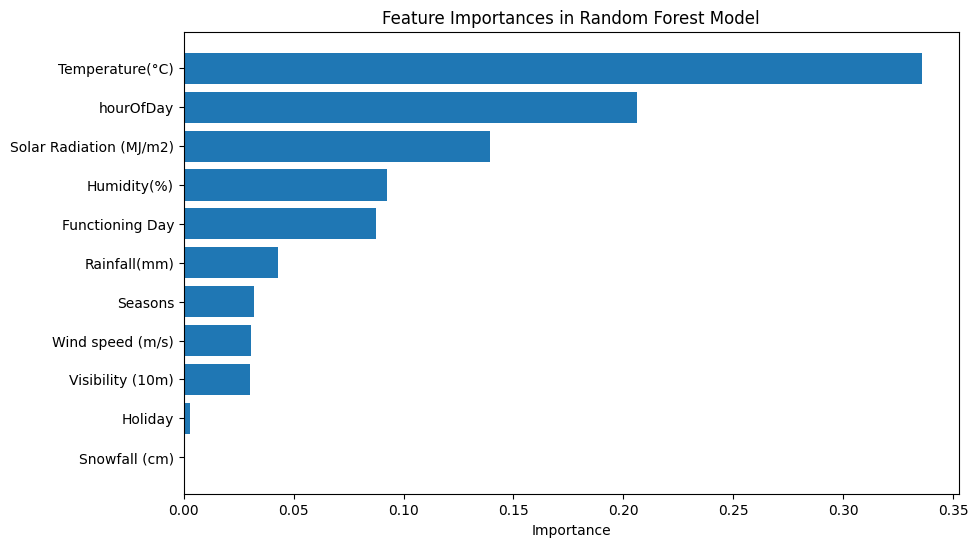

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract feature importances from the best Random Forest model
feature_importances = best_rf.feature_importances_
feature_names = X.columns  # Assuming X is your feature DataFrame

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances in Random Forest Model')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


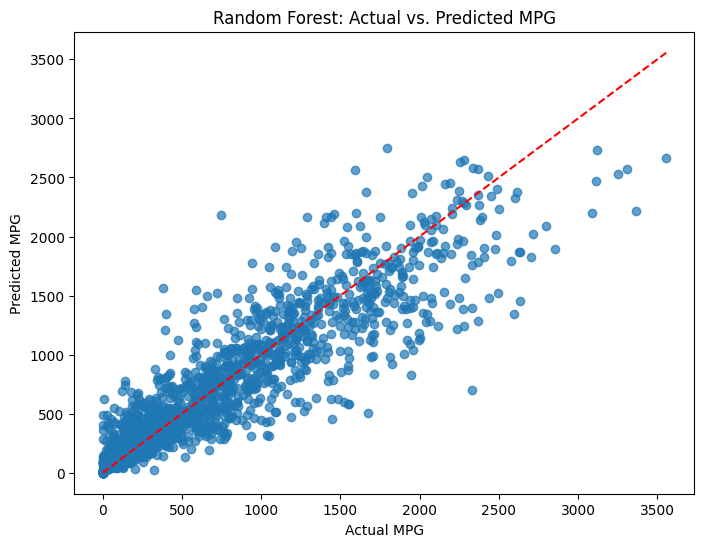

In [23]:
# Scatter plot for Random Forest predictions
plt.figure(figsize=(8,6))
plt.scatter(y_test.cpu().numpy(), rf_test_predictions, alpha=0.7)
plt.plot([y_test.cpu().min(), y_test.cpu().max()], [y_test.cpu().min(), y_test.cpu().max()], 'r--')  # Diagonal line
plt.xlabel('Actual MPG')
plt.ylabel('Predicted MPG')
plt.title('Random Forest: Actual vs. Predicted MPG')
plt.show()


In [25]:
from sklearn.model_selection import cross_val_score
# Calculate cross-validated R² scores
cv_r2_scores = cross_val_score(best_rf, X_train.cpu().numpy(), y_train.cpu().numpy().ravel(), cv=5, scoring='r2')
print(f'\nCross-Validated R² Scores: {cv_r2_scores}')
print(f'Average Cross-Validated R² Score: {cv_r2_scores.mean():.4f}')



Cross-Validated R² Scores: [0.81055458 0.83807724 0.82366025 0.84661243 0.82267248]
Average Cross-Validated R² Score: 0.8283
